### Acquiring and processing data ###

In [21]:
import json
import pandas as pd
import re

input_file = 'C:\\Users\\rohit\\Desktop\\HiWi\Work\\Radar Sensor Project\\py_mmwave_dev\\py_mmwave_plot\\log\\test_robomaster_5_mmwave_sensor_7_cfar_20240920_132223.txt'

match = re.search(r'sensor_(\d{8}_\d{6})', input_file)
if match:
    timestamp_part = match.group(1)
else:
    #raise ValueError("No timestamp found in the input file path")
    print("No timestamp found in the input file path")

#output_file = f'{timestamp_part}_parsed_data.csv'


#Initializing
data_list = []

#Read data file and parse the JSON data
with open(input_file, 'r') as file:
    for line in file:
        data = json.loads(line.strip())
        timestamp = data['timestamp']
        numObj = data['numObj']
        
        # Create a row for each object
        for i in range(numObj):
            row = {
                'timestamp': timestamp,
                'range': data['range'][i],
                'azimuth': data['azimuth'][i],
                'elevation': data['elevation'][i],
                'x': data['x'][i],
                'y': data['y'][i],
                'z': data['z'][i],
                'v': data['v'][i],
                'snr': data['snr'][i],
                'rangeProfile': data['rangeProfile'],
            }
            data_list.append(row)

#list of dictionaries to pandas DataFrame
df = pd.DataFrame(data_list)

#Displaying DataFrame
print(df.head())

#CSV output of DataFrame
#df.to_csv(output_file, index=False)

print(df.timestamp)
print(df.range)
print(df.azimuth)

No timestamp found in the input file path
      timestamp     range    azimuth  elevation      x      y      z    v  \
0  1.726831e+09  0.785295 -48.669771   2.773593 -0.589  0.518  0.038  0.0   
1  1.726831e+09  0.785500  41.859876  20.493160  0.491  0.548  0.275  0.0   
2  1.726831e+09  0.959962 -44.229251   9.715533 -0.660  0.678  0.162  0.0   
3  1.726831e+09  1.177087  -7.315858  11.267952 -0.147  1.145  0.230  0.0   
4  1.726831e+09  1.482286 -61.918343   7.364455 -1.297  0.692  0.190  0.0   

    snr                                       rangeProfile  
0  19.9  [25.321, 32.533, 35.904, 35.575, 31.608, 25.69...  
1  19.9  [25.321, 32.533, 35.904, 35.575, 31.608, 25.69...  
2  22.2  [25.321, 32.533, 35.904, 35.575, 31.608, 25.69...  
3  17.0  [25.321, 32.533, 35.904, 35.575, 31.608, 25.69...  
4   6.3  [25.321, 32.533, 35.904, 35.575, 31.608, 25.69...  
0         1.726831e+09
1         1.726831e+09
2         1.726831e+09
3         1.726831e+09
4         1.726831e+09
              

### Visualizing the Radar PtCloud Data ###

#### Interpolated Count based 2D Histogram ####

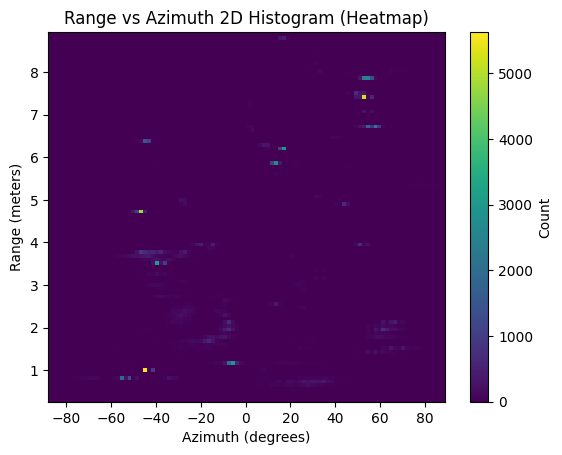

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.hist2d(df['azimuth'], df['range'], bins=[100, 100], cmap='viridis')

plt.colorbar(label='Count')

plt.xlabel('Azimuth (degrees)')
plt.ylabel('Range (meters)')
plt.title('Range vs Azimuth 2D Histogram (Heatmap)')

plt.show()

#### Interpolated SNR-based Azimuth-Range Heatmap ####

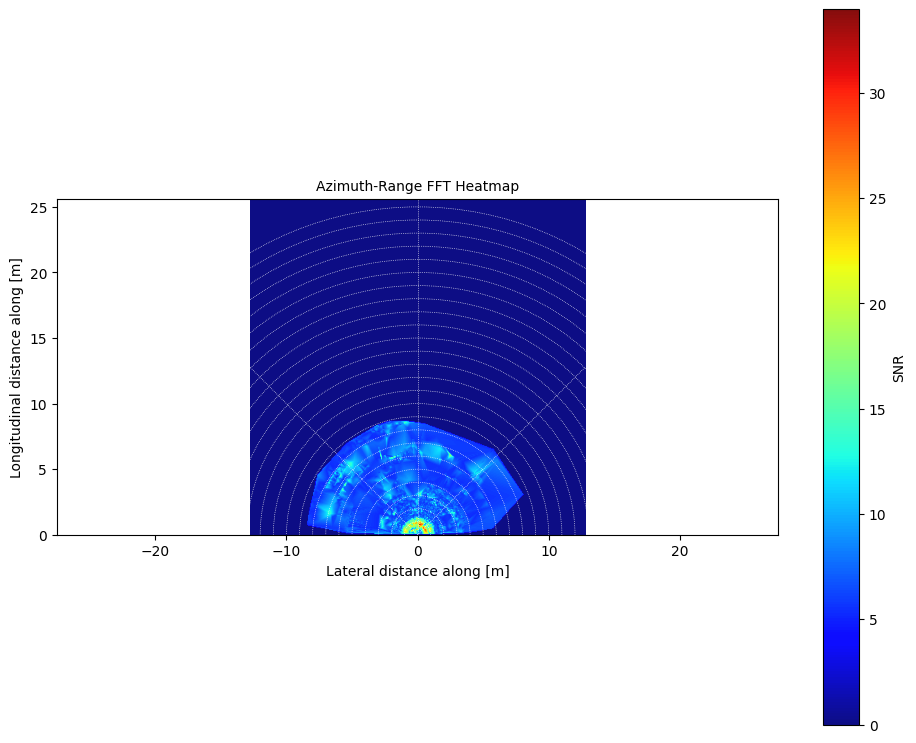

In [23]:
import scipy.interpolate as spi
import matplotlib.patches as pat
import matplotlib.widgets as wgt
#other libraries already imported previously

#Parameters
tx_azimuth_antennas = 4  
rx_antennas = 3  
range_bins = 256
angle_bins = 64
range_res = 0.1  
range_bias = 0.0 

#coordinates
t = np.linspace(-1, 1, angle_bins)
t = np.arcsin(t)
r = np.linspace(0, range_bins * range_res, range_bins)

range_depth = range_bins * range_res
range_width, grid_res = range_depth / 2, 400

xi = np.linspace(-range_width, range_width, grid_res)
yi = np.linspace(0, range_depth, grid_res)
xi, yi = np.meshgrid(xi, yi)

# x & y values for bins
x = np.outer(r, np.sin(t))
y = np.outer(r, np.cos(t))
y = y - range_bias

#Interpolating
azimuth_radians = np.radians(df['azimuth'])
x_points = df['range'] * np.sin(azimuth_radians)
y_points = df['range'] * np.cos(azimuth_radians)
values = df['snr']

#Interpolating with SNR values
zi = spi.griddata((x_points, y_points), values, (xi, yi), method='linear')
zi = np.nan_to_num(zi)  # Replace NaN values with zero

#Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)

fig.tight_layout(pad=2)

cm = ax.imshow(zi[::-1, ::-1], cmap=plt.cm.jet, extent=[-range_width, range_width, 0, range_depth], alpha=0.95)
cursor = wgt.Cursor(ax, useblit=True, color='white', linewidth=1)

ax.set_title('Azimuth-Range FFT Heatmap', fontsize=10)
ax.set_xlabel('Lateral distance along [m]')
ax.set_ylabel('Longitudinal distance along [m]')

ax.plot([0, 0], [0, range_depth], color='white', linewidth=0.5, linestyle=':', zorder=1)
ax.plot([0, -range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)
ax.plot([0, +range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)

# Range circles
for i in range(1, int(range_depth)+1):
    ax.add_patch(pat.Arc((0, 0), width=i*2, height=i*2, angle=90, theta1=-90, theta2=90, color='white', linewidth=0.5, linestyle=':', zorder=1))

plt.colorbar(cm, ax=ax, label='SNR')
plt.show() 

#### 3D PtCloud Plot without Interpolation, based on SNR values ####

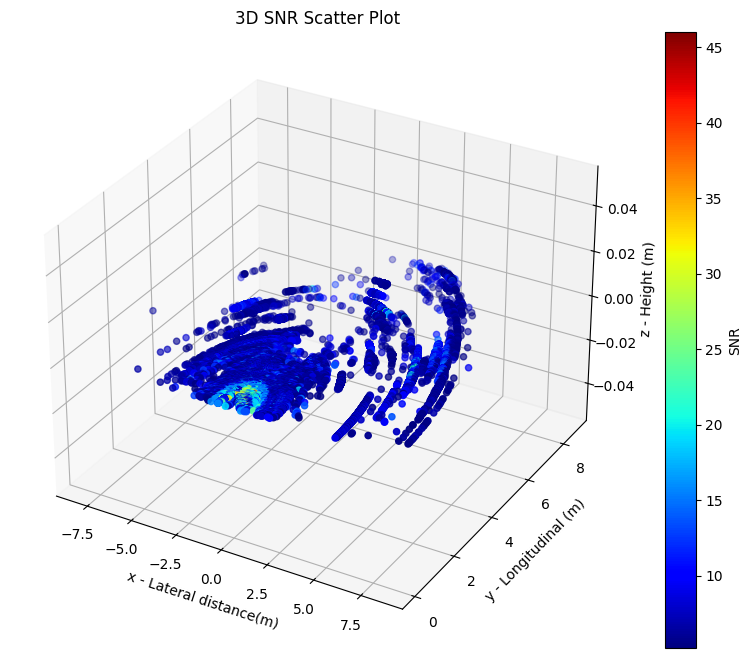

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

assert all(col in df.columns for col in ['azimuth', 'range', 'snr']), "Dataframe must contain 'azimuth', 'range', and 'snr' columns."

# Parameters for transformation
range_res = 0.1
range_bias = 0.0

# Convert azimuth to radians and calculate x, y, z coordinates
azimuth_radians = np.radians(df['azimuth'])
ranges = df['range']
snr = df['snr']

x = ranges * np.sin(azimuth_radians)
y = ranges * np.cos(azimuth_radians) - range_bias
z = np.zeros_like(x)  # Flat on the z-axis since we're only showing (x, y) and coloring by SNR

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with SNR values for color
sc = ax.scatter(x, y, z, c=snr, cmap='jet', marker='o')

# Colorbar to show SNR scale
plt.colorbar(sc, label='SNR')

# Labels and title
ax.set_title('3D SNR Scatter Plot')
ax.set_xlabel('x - Lateral distance(m)')
ax.set_ylabel('y - Longitudinal (m)')
ax.set_zlabel('z - Height (m)')  

plt.show()

#### RangeProfile ####

In [25]:
print(df.rangeProfile[1])

[25.321, 32.533, 35.904, 35.575, 31.608, 25.697, 20.382, 19.943, 21.245, 22.389, 21.95, 19.065, 17.435, 20.053, 20.978, 24.678, 30.981, 32.831, 33.599, 33.317, 31.781, 35.951, 38.381, 37.347, 32.831, 28.159, 30.464, 32.565, 31.216, 29.068, 24.302, 22.609, 20.586, 20.084, 22.718, 22.624, 20.225, 18.846, 21.37, 23.157, 23.173, 20.79, 17.874, 15.788, 16.086, 15.569, 15.318, 15.71, 18.172, 17.905, 15.569, 14.832, 14.142, 13.829, 13.405, 12.355, 10.787, 13.358, 14.942, 14.957, 17.262, 21.056, 21.292, 17.152, 15.522, 15.6, 14.55, 12.684, 15.663, 17.09, 17.764, 15.914, 16.118, 18.203, 17.952, 16.259, 15.177, 15.13, 16.713, 18.313, 18.579, 17.607, 18.767, 20.523, 20.006, 20.398, 20.006, 19.583, 17.733, 15.82, 16.227, 18.046, 16.165, 16.055, 14.989, 15.349, 14.283, 15.224, 15.459, 15.13, 15.741, 15.757, 14.503, 13.672, 14.079, 14.55, 14.644, 15.726, 18.564, 19.771, 18.187, 14.017, 12.041, 12.762, 13.656, 12.088, 9.987, 11.053, 10.317, 12.182, 11.931, 10.332, 12.762, 15.083, 14.565, 11.994, 10.7

8.93960821289166


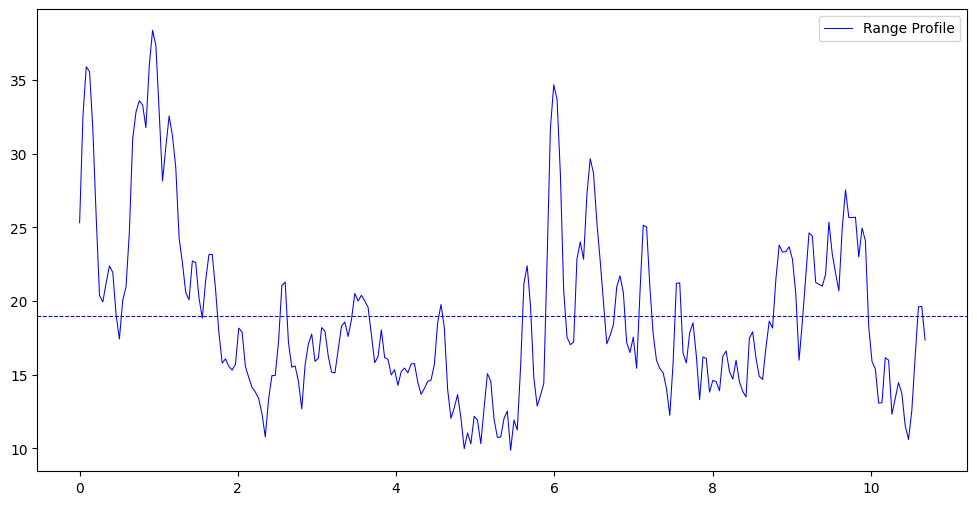

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def update(df, range_max=100, range_bias=0):
    ax.clear()

    if 'rangeProfile' in df.columns:
        y = df['rangeProfile'].values[0]  # Assuming you're interested in the first row for simplicity
        bin_size = range_max / len(y)
        x = [i * bin_size for i in range(len(y))]
        x = [v - range_bias for v in x]
        ax.plot(x, y, color='blue', linewidth=0.75, label='Range Profile')
        ax.axhline(y=np.mean(y), color='blue', linestyle='--', linewidth=0.75)
      
    ax.legend()

# Plotting data
def start_plot(df, range_bias=0):
    fig = plt.figure(figsize=(12, 6))
    global ax
    ax = plt.subplot(1, 1, 1)
    
    fig.canvas.manager.set_window_title('Range Profile')
                           
    ax.set_title('Range Profile', fontsize=10)
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Relative power [dB]')
    
    # value for max range plot
    max_range_value = df['range'].max()
    print(max_range_value)
    range_max = max_range_value * 1.2  # Adding 20% buffer to range values
    
    ax.set_xlim([0, range_max])
    ax.set_ylim([0, 100])
    ax.set_yticks(range(0, 101, 10))
    ax.grid(linestyle=':')
    
    update(df, range_max, range_bias)
    
    plt.show()

start_plot(df)

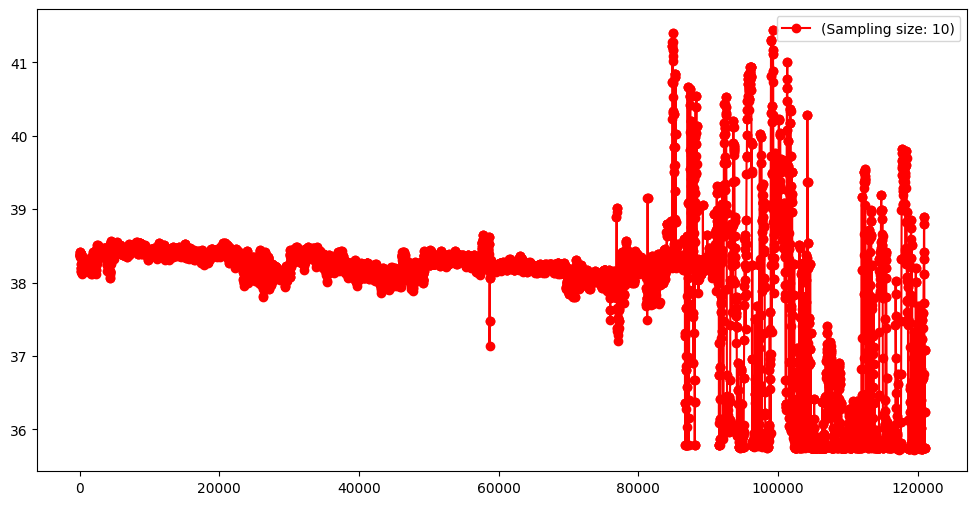

In [27]:
# Updated plotting function to get highest value from each group of 10 rows.

def update_with_grouped_peaks(df, range_max=100, range_bias=0, group_size=10):
    ax.clear()

    if 'rangeProfile' in df.columns:
        blah_values = []

        # Step 1: Extract the highest value ("blah") from each row
        for index, row in df.iterrows():
            y = row['rangeProfile']  # Accessing each row's range profile
            blah = max(y)  # Maximum value in that row's range profile
            blah_values.append(blah)
        
        # Step 2: Group by every 10 rows and get the highest "blah" in each group
        grouped_peaks = []
        num_rows = len(blah_values)

        for i in range(0, num_rows, group_size):
            group = blah_values[i:i+group_size]  # Taking groups of 10
            highest_blah = max(group)  # Get highest value in each group
            grouped_peaks.append(highest_blah)

        # Step 3: Calculate x-axis based on the number of grouped peaks
        x = np.arange(1, len(grouped_peaks) + 1) * group_size  # X-axis values for plotting

        # Plot the grouped peaks
        ax.plot(x, grouped_peaks, 'ro-', label='(Sampling size: 10)')
        
        ax.legend()

# Plotting function updated
def start_plot_with_grouped_peaks(df, range_bias=0, group_size=10):
    fig = plt.figure(figsize=(12, 6))
    global ax
    ax = plt.subplot(1, 1, 1)
    
    fig.canvas.manager.set_window_title('Range Profile (Grouped Peaks)')
    
    ax.set_title('Range Profile (Grouped Peaks)', fontsize=10)
    ax.set_xlabel('##for later')
    ax.set_ylabel('Max value [dB]')
    
    ax.grid(linestyle=':')
    
    # Update plot with grouped peaks
    update_with_grouped_peaks(df, range_bias, group_size=group_size)
    
    plt.show()

# The function is now ready for use. 
# You can call start_plot_with_grouped_peaks(df) with your DataFrame `df`.
start_plot_with_grouped_peaks(df)


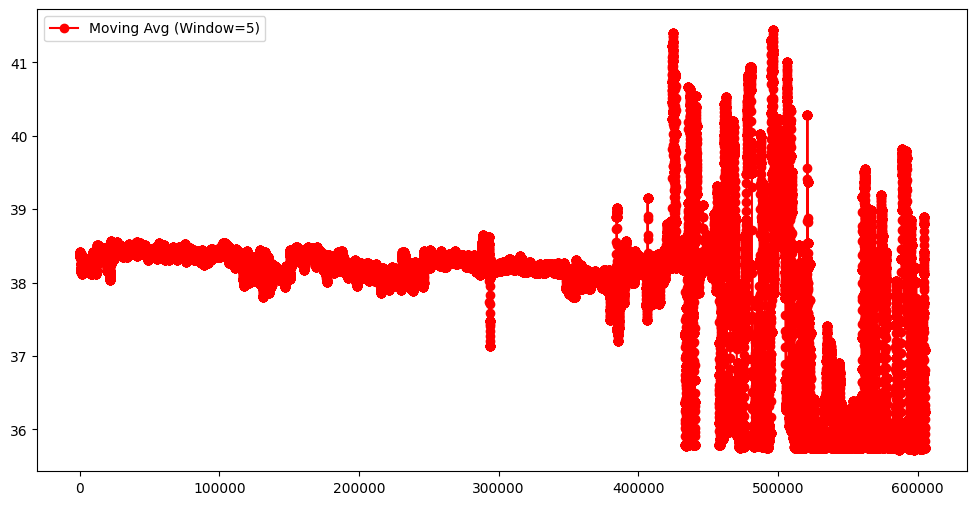

In [28]:
# Moving Average Filter function
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Updated function to use moving average filter with 5-point window
def update_with_moving_average(df, range_max=100, range_bias=0, window_size=5):
    ax.clear()

    if 'rangeProfile' in df.columns:
        blah_values = []

        # Step 1: Extract the highest value ("blah") from each row
        for index, row in df.iterrows():
            y = row['rangeProfile']  # Accessing each row's range profile
            blah = max(y)  # Maximum value in that row's range profile
            blah_values.append(blah)

        # Step 2: Apply moving average filter with a window size of 5
        smoothed_blah_values = moving_average(blah_values, window_size)

        # Step 3: Calculate x-axis based on the number of smoothed values
        x = np.arange(1, len(smoothed_blah_values) + 1) * window_size  # X-axis values for plotting

        # Plot the smoothed "blah" values
        ax.plot(x, smoothed_blah_values, 'ro-', label=f'Moving Avg (Window={window_size})')
        
        ax.legend()

# Plotting function updated with moving average filter
def start_plot_with_moving_average(df, range_bias=0, window_size=5):
    fig = plt.figure(figsize=(12, 6))
    global ax
    ax = plt.subplot(1, 1, 1)
    
    fig.canvas.manager.set_window_title('Range Profile (Smoothed Moving Average)')
    
    ax.set_title(f'Range Profile (Moving Average with Window={window_size})', fontsize=10)
    ax.set_xlabel('Row Group (Each representing {window_size} rows)')
    ax.set_ylabel('Smoothed Max value [dB]')
    
    ax.grid(linestyle=':')
    
    # Update plot with smoothed values
    update_with_moving_average(df, range_bias, window_size=window_size)
    
    plt.show()

start_plot_with_moving_average(df)